In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn 
import statsmodels.api as sm

import data_functions as fn

In [2]:
# Read in the list of teams
teams = pd.read_csv('DataFiles/Teams.csv')
seasons_data = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
file_list = {}
years = ['18','17','16','15','14','13','12','11','10','09','08','07','06','05','04','03','02','01','00']

# Read in the data files from sports-reference.com
for s in years:
    filepath = ('WebData/ratings_' + s + '.csv')
    raw_data = pd.read_csv(filepath).drop(['Unnamed: 3', 'Unnamed: 9', 'Unnamed: 11'], axis=1)
    # We need only the school name and the rank
    raw_data = raw_data[['Rk', 'School']].dropna()
    raw_data = raw_data[(raw_data['Rk']).str.isnumeric()]
    file_list[s] = raw_data

In [3]:
# Extract the dataframes from the list
df_18 = file_list['18']
df_17 = file_list['17']
df_16 = file_list['16']
df_15 = file_list['15']
df_14 = file_list['14']
df_13 = file_list['13']
df_12 = file_list['12']
df_11 = file_list['11']
df_10 = file_list['10']
df_09 = file_list['09']
df_08 = file_list['08']
df_07 = file_list['07']
df_06 = file_list['06']
df_05 = file_list['05']
df_04 = file_list['04']
df_03 = file_list['03']
df_02 = file_list['02']
df_01 = file_list['01']
df_00 = file_list['00']
# Rename the columns
df_18.columns = ['2018', 'School']
df_17.columns = ['2017', 'School']
df_16.columns = ['2016', 'School']
df_15.columns = ['2015', 'School']
df_14.columns = ['2014', 'School']
df_13.columns = ['2013', 'School']
df_12.columns = ['2012', 'School']
df_11.columns = ['2011', 'School']
df_10.columns = ['2010', 'School']
df_09.columns = ['2009', 'School']
df_08.columns = ['2008', 'School']
df_07.columns = ['2007', 'School']
df_06.columns = ['2006', 'School']
df_05.columns = ['2005', 'School']
df_04.columns = ['2004', 'School']
df_03.columns = ['2003', 'School']
df_02.columns = ['2002', 'School']
df_01.columns = ['2001', 'School']
df_00.columns = ['2000', 'School']

In [4]:
# Merge the dataframes
from functools import reduce
data_frames = [df_18, df_17, df_16, df_15, df_14, df_13, df_12, df_11, df_10, df_09, df_08, 
               df_07, df_06, df_05, df_04, df_03, df_02, df_01, df_00]

team_ranks_df = reduce(lambda left, right: pd.merge(left, right, on=['School'], how='outer'), data_frames)

team_ranks_df = team_ranks_df.dropna().reset_index().drop('index', axis=1)

In [5]:
# Convert the rankings to integers
for col in team_ranks_df.columns:
    if str(col) != 'School':
        team_ranks_df[col] = team_ranks_df[col].astype(int)
        
team_ranks_df.head(2)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,1,Villanova,5,1,5,9,51,71,23,17,14,47,19,6,13,50,59,50,75,72
1,2,Duke,9,12,2,6,4,12,2,1,6,5,11,2,3,1,6,1,1,2


In [6]:
team_ranks_df.to_csv('TeamRankings.csv')

### Look at the autocorrelation of the team rankings

In [7]:
ac_data = team_ranks_df.drop(['School'], axis=1)
# Create a list of lists of the autocorrelation 
ac_list = []

for i in ac_data.index:
    d = ac_data.loc[i].values.astype(float)
    ac = sm.tsa.stattools.acf(d)
    ac_list.append(ac)

In [8]:
# Data for plotting
plot_data = []
for i in range(0, len(ac_list[0])):
    r_list = []
    for ac in ac_list:
        x = ac[i]
        r_list.append(x)
    plot_data.append(r_list)

plot_data = plot_data[1:]

In [9]:
labels = []

for c in ac_data.columns[1:]:
    labels.append(c)

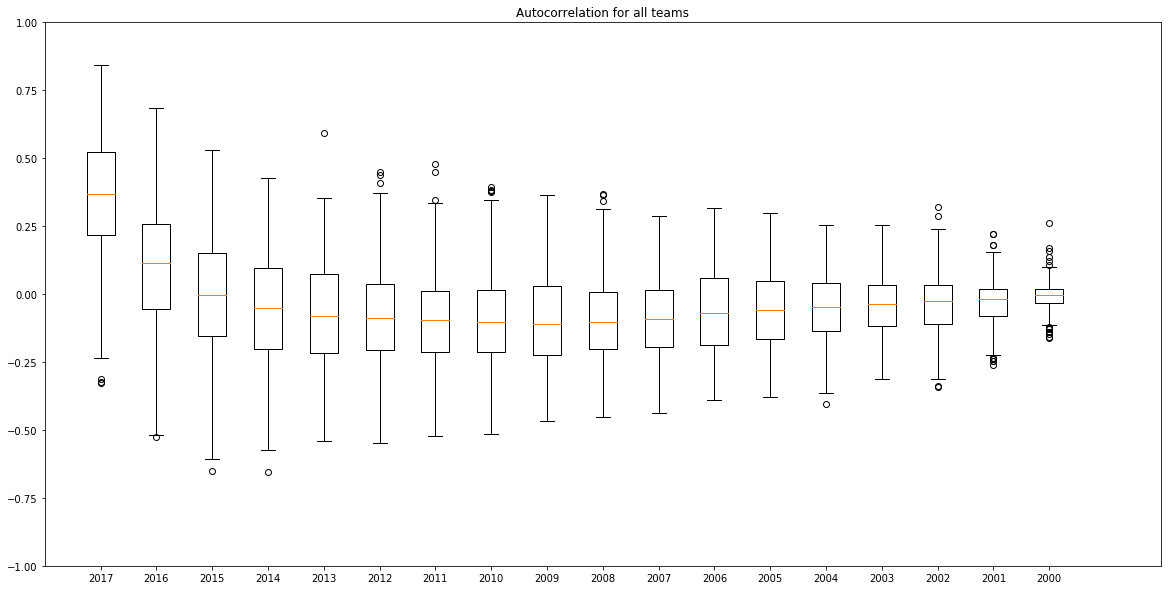

In [10]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title('Autocorrelation for all teams')
_= plt.boxplot(plot_data, labels = labels)
plt.axis([0, 20, -1, 1])
plt.savefig('Autocorrelation_boxplots.png')
plt.show()

### From the plots above, we can see that there is a correlation for the previous two years, but after that it is basically zero. This indicates that the data from the previous two years may be useful for predicting outcomes for the current year.

In [11]:
# Look at the regular season data
seasons_data.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16


In [12]:
#Include only teams that have been Division I teams in the years included in the rankings data
teams = teams[teams.LastD1Season > 1999]

# Replace 'St' with 'State' in the TeamName column to correspond to the School column in the rest of the data
schools = []
for t in teams.TeamName:
    name = str(t)
    r_name = re.sub(' St', " State", name)
    schools.append(r_name)

teams.TeamName = schools

In [13]:
# Create a dictionary with the team name and team id
teams_dict = {}

for i in teams.index:
    teams_dict[teams.TeamName[i]] = teams.TeamID[i]

# Create a dataframe with the team name and team id
team_id_df = pd.DataFrame()
team_id_df['TeamName'] = teams_dict.keys()
team_id_df['TeamID'] = teams_dict.values()

team_id_df.to_csv('Team_id_pairs.csv')

In [14]:
# Create a list with the team ids
team_id_list = []

for i in team_ranks_df.index:
    s = str(team_ranks_df.School[i])
    if s in teams_dict:
        team_id = teams_dict[s]
        team_id_list.append(team_id)
    elif s not in teams_dict:
        team_id_list.append(np.nan)
        
team_ranks_df['TeamID'] = team_id_list

team_ranks_df = team_ranks_df.set_index('TeamID')

### Calculate the average field goal rate for each team for 2008 - 2018



In [15]:
# Extract the data needed
fg_data = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WFGM', 'WFGA', 'LFGM', 'LFGA']]

fg_data['Lfgr'] = fg_data.LFGM/fg_data.LFGA
fg_data['Wfgr'] = fg_data.WFGM/fg_data.WFGA
fg_data = fg_data.reset_index().drop('index', axis=1)

years = fg_data.Season.unique()
fg_list = fn.calculate_rates(years, fg_data, 'Wfgr', 'Lfgr')
# Build a dataframe with the field goal rates for each team for each year
fgr_df = fn.build_df(fg_list, years, 'FG_rate')

### Calculate the averate free throw rates

In [16]:
# Calculate free throw rates
ft_data = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WFTM', 'WFTA', 'LFTM', 'LFTA']]

ft_data['Lftr'] = ft_data.LFTM/ft_data.LFTA
ft_data['Wftr'] = ft_data.WFTM/ft_data.WFTA

ft_list = fn.calculate_rates(years, ft_data, 'Wftr', 'Lftr')
ftr_df = fn.build_df(ft_list, years, 'FT_rate')

### Calculate the average 3 point rate

In [17]:
# Calculate the 3 point rate
fg3_data = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WFGA3', 'WFGM3', 'LFGA3', 'LFGM3']]

fg3_data['Lfg3r'] = fg3_data.LFGM3/fg3_data.LFGA3
fg3_data['Wfg3r'] = fg3_data.WFGM3/fg3_data.WFGA3

# Calculate the rates for each year
fg3_list = fn.calculate_rates(years, fg3_data, 'Wfg3r', 'Lfg3r')
# Build a dataframe with the free throw rates for each team for each year
fg3r_df = fn.build_df(fg3_list, years, 'FG3_rate')

### Calculate average number of rebounds, steals, and blocks for each team per year

In [18]:
avg_data = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WOR', 'LOR', 'WDR', 'LDR',
                                                  'WStl', 'LStl', 'WBlk', 'LBlk', 'WAst', 'LAst', 'WPF', 'LPF']]

orb_list = fn.calculate_average(years, avg_data, 'WOR', 'LOR')
drb_list = fn.calculate_average(years, avg_data, 'WDR', 'LDR')
stl_list = fn.calculate_average(years, avg_data, 'WStl', 'LStl')
blk_list = fn.calculate_average(years, avg_data, 'WBlk', 'LBlk')
ast_list = fn.calculate_average(years, avg_data, 'WAst', 'LAst')
pf_list = fn.calculate_average(years, avg_data, 'WPF', 'LPF')

In [19]:
orb_df = fn.build_df(orb_list, years, 'ORB')
drb_df = fn.build_df(drb_list, years, 'DRB')
stl_df = fn.build_df(stl_list, years, 'STL')
blk_df = fn.build_df(blk_list, years, 'BLK')
ast_df = fn.build_df(ast_list, years, 'AST')
pf_df = fn.build_df(pf_list, years, 'PF')

### Calculate average difference in scores for each game

In [20]:
score_df = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore']]
score_diff = [(score_df.WScore[i] - score_df.LScore[i]) for i in score_df.index]
score_df['Score_Diff'] = score_diff

score_diff_list = fn.calculate_average(years, score_df, 'Score_Diff', 'Score_Diff')
score_df = fn.build_df(score_diff_list, years, 'Score_Diff')

### Extract the columns needed from the original data so that it can be merged with the features created above.

In [23]:
data = seasons_data[seasons_data.Season>2008][['WTeamID','LTeamID','Season','DayNum']]                                                                                          
data['W_opp'] = data.LTeamID
data['L_opp'] = data.WTeamID
data.head(2)

,WTeamID,LTeamID,Season,DayNum,W_opp,L_opp
28825,1181,1342,2009,7,1342,1181
28826,1204,1222,2009,7,1222,1204


In [24]:
data2 = data.set_index(['Season', 'DayNum', 'W_opp', 'L_opp']).stack().reset_index()

In [25]:
# Add a column of ones and zeros, indicating whether the team won or lost
win = []

for i in data2.index:
    if data2.level_4[i].startswith('W'):
        win.append(1)
    elif data2.level_4[i].startswith('L'):
        win.append(0)
        
data2['Win'] = win

data2.head()

,Season,DayNum,W_opp,L_opp,level_4,0,Win
0,2009,7,1342,1181,WTeamID,1181,1
1,2009,7,1342,1181,LTeamID,1342,0
2,2009,7,1222,1204,WTeamID,1204,1
3,2009,7,1222,1204,LTeamID,1222,0
4,2009,8,1204,1181,WTeamID,1181,1


In [26]:
Opp = []
for i in data2.index:
    if data2.Win[i]==1:
        Opp.append(int(data2.W_opp[i]))
    elif data2.Win[i]==0:
        Opp.append(int(data2.L_opp[i]))
        
data2['Opp_TeamID'] = Opp
data2 = data2.drop(['W_opp', 'L_opp', 'level_4'], axis=1)
data2.columns = ['Season', 'DayNum', 'TeamID', 'Win', 'Opp_TeamID']
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106432 entries, 0 to 106431
Data columns (total 5 columns):
Season        106432 non-null int64
DayNum        106432 non-null int64
TeamID        106432 non-null int64
Win           106432 non-null int64
Opp_TeamID    106432 non-null int64
dtypes: int64(5)
memory usage: 4.1 MB


In [27]:
all_dfs = [data2, fgr_df, ftr_df, fg3r_df, orb_df, drb_df, stl_df, blk_df, ast_df, pf_df, score_df]

In [28]:
combined_data = reduce(lambda left, right: pd.merge(left, right, on=['TeamID', 'Season'], how='outer'), all_dfs)

In [29]:
combined_data2 = combined_data.dropna()

In [31]:
combined_data2.loc[:,'Opp_TeamID']=(combined_data2.Opp_TeamID).astype(int)

combined_data2.head()

,Season,DayNum,TeamID,Win,Opp_TeamID,FG_rate,FT_rate,FG3_rate,ORB,DRB,STL,BLK,AST,PF,Score_Diff
0,2009,7.0,1181,1.0,1342,0.439811,0.711419,0.345149,13.403704,24.340741,7.918519,3.266667,14.285185,20.477778,11.977778
1,2009,8.0,1181,1.0,1204,0.439811,0.711419,0.345149,13.403704,24.340741,7.918519,3.266667,14.285185,20.477778,11.977778
2,2009,13.0,1181,1.0,1348,0.439811,0.711419,0.345149,13.403704,24.340741,7.918519,3.266667,14.285185,20.477778,11.977778
3,2009,17.0,1181,1.0,1356,0.439811,0.711419,0.345149,13.403704,24.340741,7.918519,3.266667,14.285185,20.477778,11.977778
4,2009,18.0,1181,1.0,1276,0.439811,0.711419,0.345149,13.403704,24.340741,7.918519,3.266667,14.285185,20.477778,11.977778


### Add the data for the losing team

In [32]:
# Rename the columns to indicate the features for the losing team
opp_list = []

for df in all_dfs[1:]:
    new_df = fn.rename_columns(df)
    opp_list.append(new_df)

In [33]:
dfs2 = [combined_data2]
for i in opp_list:
    dfs2.append(i)

In [34]:
# Merge the dataframes
all_data = reduce(lambda left, right: pd.merge(left, right, on=['Opp_TeamID', 'Season'], how='outer'), dfs2)

In [39]:
all_data.head()

,Season,DayNum,TeamID,Win,Opp_TeamID,FG_rate,FT_rate,FG3_rate,ORB,DRB,...,Opp_FG_rate,Opp_FT_rate,Opp_FG3_rate,Opp_ORB,Opp_DRB,Opp_STL,Opp_BLK,Opp_AST,Opp_PF,Opp_Score_Diff
0,2009,7.0,1181.0,1.0,1342,0.439811,0.711419,0.345149,13.403704,24.340741,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
1,2009,8.0,1222.0,1.0,1342,0.410627,0.780318,0.350825,12.318182,23.901515,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
2,2009,25.0,1155.0,1.0,1342,0.453876,0.592604,0.352820,15.828502,22.785024,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
3,2009,33.0,1219.0,0.0,1342,0.451474,0.753390,0.371754,10.527473,23.214286,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
4,2009,89.0,1219.0,0.0,1342,0.451474,0.753390,0.371754,10.527473,23.214286,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05


In [36]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103707 entries, 0 to 103706
Data columns (total 25 columns):
Season            103707 non-null int64
DayNum            103704 non-null float64
TeamID            103704 non-null float64
Win               103704 non-null float64
Opp_TeamID        103707 non-null int64
FG_rate           103704 non-null float64
FT_rate           103704 non-null float64
FG3_rate          103704 non-null float64
ORB               103704 non-null float64
DRB               103704 non-null float64
STL               103704 non-null float64
BLK               103704 non-null float64
AST               103704 non-null float64
PF                103704 non-null float64
Score_Diff        103704 non-null float64
Opp_FG_rate       101171 non-null float64
Opp_FT_rate       101171 non-null float64
Opp_FG3_rate      101171 non-null float64
Opp_ORB           101171 non-null float64
Opp_DRB           101171 non-null float64
Opp_STL           101171 non-null float64
Opp_BLK    

In [37]:
all_data.to_csv('BasketballData.csv')